In [1]:
#!pip install tta_wrapper --user

In [1]:
import os
import sys

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
sys.path.append('..')
from skimage.morphology import remove_small_objects, label

In [2]:
from keras.models import load_model

Using TensorFlow backend.


In [3]:
### Functions
import numpy as np


def get_shape(x, split_size, overlap):
    """
    Calculate shape `X` nearest, but bigger than `x` by `split_size` and `overlap`:
        `X = split_size * n - overlap * (n - 1)`, where `n` is integer 
        
    Args:
        x (int): size 
        split_size (int): segment lenght
        overlap (int): number of pixels shareable between neighbour segments
    
    Return:
        x (int): suitable shape 
    """
    if x <= split_size - overlap:
        return split_size 
    elif x <= split_size:
        x += overlap
        
    size = split_size - overlap
    x_ = x - overlap
    x = (x_ // size + 1) * size + overlap
    return x

            
def pad(image, divisible_by=128):
    """
    Add additional pixels to image to make it divisible by provided number
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
         (int): size of tiles in pixels, should be 2^n and 
         divisible_by (int): number of pixels
            
    Return:
        image (numpy.ndarray): image with shape divisible by provided number
        paddings (list of tuples): numbers of pixels added on each side
            ((padding_top, padding_bottom), (padding_left, padding_right), (...)) 
        
    """
    h, w = image.shape[:2]

    func = lambda x:(divisible_by - x % divisible_by) / 2
    
    pad_h_top = np.floor(func(h)).astype(np.int_)
    pad_h_bot = np.ceil(func(h)).astype(np.int_)
    pad_w_left = np.floor(func(w)).astype(np.int_)
    pad_w_right = np.ceil(func(w)).astype(np.int_)

    paddings = ((pad_h_top, pad_h_bot), 
                (pad_w_left, pad_w_right), 
                (0,0))

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)

    image = np.pad(image, paddings, mode='reflect')

    return image, paddings


def pad_shape(image, shape):
    """
    Add additional pixels to image to make it provided shape
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        shape (tuple of int): size of output image
            
    Return:
        image (numpy.ndarray): image with `shape`
        paddings (list of tuples): numbers of pixels added on each side
            ((padding_top, padding_bottom), (padding_left, padding_right), (...)) 
        
    """
        
    h, w = image.shape[:2]
    target_h, target_w = shape
    
    assert target_h > h
    assert target_w > w
    
    pad_h_top = int(np.floor((target_h - h)/2))
    pad_h_bot = int(np.ceil((target_h - h)/2))
    pad_w_left = int(np.floor((target_w - w)/2))
    pad_w_right = int(np.ceil((target_w - w)/2))

    paddings = ((pad_h_top, pad_h_bot), 
                (pad_w_left, pad_w_right), 
                (0,0))

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)

    image = np.pad(image, paddings, mode='reflect')

    return image, paddings


def unpad(image, paddings):
    """ 
    Delete paddings on picture
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        paddings (list of tuples): numbers of pixels to be deleted on each side
            ((padding_top, padding_bottom), (padding_left, padding_right), (...)) 
        
    Return:
        image (numpy.ndarray): cropped image
    """
    h, w = image.shape[:2]

    h_top, h_bot = paddings[0]
    w_left, w_right = paddings[1]

    image = image[h_top:h-h_bot, w_left:w-w_right]

    return image        
           


def split(image, split_size=1024):
    """
    Split image to tiles of size `split_size x split_size` and return list of them
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        split_size (int): size of tiles in pixels, should be 2^n and 
            image`s width and height should be divisible by split_size
            
    Return:
        images (list of numpy.ndarray): list of tiles of size `split_size x split_size`
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` equal to number of images
    """
    h, w = image.shape[:2]

    assert h % split_size == 0
    assert w % split_size == 0

    n_rows = h // split_size
    n_cols = w // split_size

    h_size = h // n_rows
    w_size = w // n_cols

    ws = np.linspace(0, h, n_rows+1).astype(np.int_)[:-1]
    hs = np.linspace(0, w, n_cols+1).astype(np.int_)[:-1]

    images = []

    for h_ in hs:
        for w_ in ws:
            crop_image = image[h_:h_+h_size, w_:w_+w_size]
            images.append(crop_image)

    return images, n_rows, n_cols


def overlap_split(image, split_size, overlap):
    """
    Split image to tiles of size `split_size x split_size` and return list of them.
    To make percise splitting images shapes should be divisible by `split_size`
    
    Args:
        image (numpy.ndarray): 2d or 3d numpy.ndarray (n_rows x n_cols x n_channels)
        split_size (int): size of tiles in pixels, should be 2^n and 
            image`s width and height should be divisible by split_size
        overlap (int): number of pixels shareable between neighbour tiles
            
    Return:
        images (list of numpy.ndarray): list of tiles of size `split_size x split_size`
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` equal to number of images
    """
    
    h, w = image.shape[:2]
    
    n_rows = int((h - overlap) / (split_size - overlap))
    n_cols = int((w - overlap) / (split_size - overlap))

    w_size = split_size - overlap
    h_size = split_size - overlap

    images = []

    for i in range(n_rows):
        h_ = i * h_size
        for j in range(n_cols):
            w_ = j * w_size
            crop_image = image[h_:h_+split_size, w_:w_+split_size]
            images.append(crop_image)

    return images, n_rows, n_cols


def concatenate(images, n_rows, n_cols):
    """
    Concatenate list of images into ine big image according to number of rows and colums
    
    Args:
        images (list of numpy.ndarray): list of images(tiles) - 2d or 3d arrays with same shape
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` should be equal to number of images
    Return:
        image (numpy.ndarray): reconstructed image with shape tile_height*n_rows, tile_widht*n_cols
    
    """

    assert len(images) == n_rows * n_cols

    rows = []

    for i in range(n_rows):
        row = np.concatenate(images[i*n_cols:(i+1)*n_cols], axis=1)
        rows.append(row)

    img = np.concatenate(rows, axis=0)

    return img


def overlap_concatenate(images, n_rows, n_cols, overlap):
    """
    Concatenate list of images into ine big image according to number of rows and colums
    
    Args:
        images (list of numpy.ndarray): list of images(tiles) - 2d or 3d arrays with same shape
        n_rows, n_cols (int): number of rows and cols to reconstruct original image,
            `n_rows * n_cols` should be equal to number of images
        overlap (int): number of pixels shareable between neighbour tiles
        
    Return:
        image (numpy.ndarray): reconstructed image with shape
            `image_width = tile_width * n_cols - overlap * (n_cols - 1)`
            `image_height = tile_height * n_rows - overlap * (n_rows - 1)`
    
    """
    crop_images = []
    for i in range(n_rows):
        for j in range(n_cols):
            index = i*n_cols+j
            
            h_pad_top = overlap // 2 if i!=0 else 0
            h_pad_bot = overlap // 2 if i!=n_rows-1 else 0
            w_pad_left = overlap // 2 if j!=0 else 0
            w_pad_right = overlap // 2 if j!=n_cols-1 else 0
            
            paddings = ((h_pad_top, h_pad_bot),
                       (w_pad_left, w_pad_right),
                       (0,0))
            
            img = unpad(images[index], paddings)
            crop_images.append(img)
    
    image = concatenate(crop_images, n_rows, n_cols)
    
    return image



In [4]:
def predict(image, model, split_size=1024, overlap=256):

    h, w = image.shape[:2]

    h = get_shape(h, split_size, overlap)
    w = get_shape(w, split_size, overlap)

    print('.', end='')
    image, paddings = pad_shape(image, (h, w))
    images, n_rows, n_cols = overlap_split(image, split_size, overlap)

    predictions = []

    #print('processing...')

    for image in images:
        image = np.expand_dims(image, axis=0)  # input image have to be 4d tensor
        pred = model.predict(image)
        pred = np.squeeze(pred)
        predictions.append(pred)

    #print('merging tiles...', end='')

    if len(predictions) > 1:
        prediction = overlap_concatenate(predictions, n_rows, n_cols, overlap)
    else:
        prediction = np.squeeze(predictions)
    prediction = unpad(prediction, paddings)
    print('!')
    return prediction

### Loading model

In [5]:
from tqdm import tqdm_notebook as tqdm
from tta_wrapper import tta_segmentation

In [7]:
path_models_0 = [
    '../../checkpoints/exp-1/ep_31-score_0.91368.h5',
    '../../checkpoints/exp-2/ep_26-score_0.92291.h5',
    '../../checkpoints/exp-3/ep_28-score_0.92761.h5',
    '../../checkpoints/exp-4/ep_26-score_0.92817.h5',
    '../../checkpoints/exp-8/ep_26-score_0.92602.h5',
]

path_models_1 = [
    '../../checkpoints/exp-1-oof-1/ep_28-score_0.9243.h5',
    '../../checkpoints/exp-2-oof-1/ep_27-score_0.92468.h5',
    '../../checkpoints/exp-3-oof-1/ep_27-score_0.92481.h5',
    '../../checkpoints/exp-4-oof-1/ep_21-score_0.9286.h5',
]

In [8]:
def load_tta_model(path):
    return tta_segmentation(
        load_model(path, compile=False),
        h_flip=True, 
        v_flip=True,
    )

In [9]:
models_0 = [load_tta_model(p) for p in tqdm(path_models_0)]

A Jupyter Widget

In [10]:
models_1 = [load_tta_model(p) for p in tqdm(path_models_1)]

A Jupyter Widget

In [11]:
b_model = load_tta_model('../../checkpoints/exp-5/ep_29-score_0.39022.h5')

### Loading data

In [12]:
import cv2

def read_image(path):
    return cv2.imread(path)[..., ::-1].copy()

def save_mask(path, image):
    cv2.imwrite(path, image * 255)
    

def predict_ensemble(image, models, split_size=1024):
    
    predictions = []
    for model in models:
        pred = predict(image, model, split_size=split_size).squeeze()
        predictions.append(pred)
        
    pred = np.stack(predictions, axis=0).mean(axis=0)
    return pred
    
def predict_all_folds(image, folds_models, split_size=1024):
    
    predictions = []
    for fold_models in folds_models:
        pred = predict_ensemble(image, fold_models, split_size=split_size).squeeze()
        predictions.append(pred)
        
    pred = np.stack(predictions, axis=0).mean(axis=0)
    return pred

def postprocessing(pred, bord, min_size=100):
    
    pr = (pred - bord).clip(0, 1)
    pr = pr.round()
    pr = remove_small_objects(label(pr), min_size).clip(0, 1)
    
    return pr

In [13]:
LOAD_DIR = '../../data/dataset/test_2/'
SAVE_DIR = '../../data/predictions/test_2/sub-3/'
os.makedirs(SAVE_DIR, exist_ok=True)

In [14]:
for id in os.listdir(LOAD_DIR):
    #id = '2YNGEOYOEH0YXBJV.png'  
    print(id)
    src_path = os.path.join(LOAD_DIR, id)
    image = read_image(src_path)

    # prediction
    pred = predict_all_folds(image, [models_0, models_1]).squeeze()
    dst_path = os.path.join(SAVE_DIR, id)
    #save_mask(dst_path, pred)

    # add posprocessing
    bord = predict(image, b_model)
    post_pred = postprocessing(pred, bord)

    # save
    dst_path = os.path.join(SAVE_DIR, id)
    save_mask(dst_path, post_pred)

ZRYNEEUSVQ213QTY.png
.!
.!
.!
.!
.!
.!
.!
.!
.!
.!
P2MLF2MV9K9XIYUI.png
.!
.!
.!
.!
.!
.!
.!
.!
.!
.!
KHSF2T5PXCKI0978.png
.!
.!
.!
.!
.!
.!
.!
.!
.!
.!


# Validation

In [48]:
import os
import cv2

import pandas as pd
import numpy as np

from torch.utils.data import Dataset

In [49]:
def read_image(path):
    return cv2.imread(path)[..., ::-1].copy()

def read_mask(path):
    return cv2.imread(path, 0).squeeze() / 255

class BuildingsDataset(Dataset):
    
    def __init__(self, ids, images_dir, masks_dir, transform=None):
        self.ids = ids
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        
        print('Reading images...')
        self.images = {id: read_image(os.path.join(images_dir, id)) for id in ids}
        
        print('Reading masks...')
        self.masks = {id: read_mask(os.path.join(masks_dir, id)) for id in ids}
        
    def __getitem__(self, i):
        
        id = self.ids[i]
        
        sample = {
            'image': self.images[id],
            'mask': self.masks[id],
        }
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample
        
    def __len__(self):
        return len(self.ids)

# augs
import albumentations as alb

valid_transfroms = [
    
    alb.RandomCrop(1024, 1024),
]
valid_aug = alb.Compose(valid_transfroms)


# transfroms
import sys
sys.path.append('..')

from utils.datasets import make_transform

valid_transform = make_transform(augmenter=valid_aug)

In [50]:
DATA_DIR = '../../data/dataset/train/'

IMAGES_DIR = os.path.join(DATA_DIR, 'images')
MASKS_DIR = os.path.join(DATA_DIR, 'masks')
valid_ids = ['AZ74029PBGFI0291.png', 'T4ZUFU91883CRMQ3.png', 'FOCNEZJJ9UP6IPIC.png']

In [51]:
valid_dataset = BuildingsDataset(valid_ids, IMAGES_DIR, MASKS_DIR, transform=valid_transform)

Reading images...
Reading masks...


In [80]:
# metric 
from utils.metrics import f2_score


scores = []

for i in tqdm(range(40)):
    
    sample = valid_dataset[np.random.randint(3)]
    
    image = sample['image']
    gt = sample['mask'].squeeze()
    
    pr = predict_ensemble(image, models_0[:3], split_size=512)
    
    b = predict(image, b_model)
    
    pr = (pr - b).clip(0, 1)
    
    pr = pr.round()
    pr = remove_small_objects(label(pr), 100).clip(0, 1)
    
#     print(gt.shape)
#     print(pr.shape)
    
#     plt.imshow(image)
#     plt.show()

#     plt.imshow(gt)
#     plt.show()

#     plt.imshow(pr)
#     plt.show()

    score = f2_score(gt, pr)
    scores.append(score)
    
print(np.mean(scores))

A Jupyter Widget

0.658230341302


In [ ]:
# 1 model - score 0.5673
# 2 models - score 0.6351
# 3 models - score 0.6531/0.6508/0.6582
# 4 models - score 0.6245
# 5 models - score 0.6165/0.6432

THRESHOLD = 0.5
SMALL_OBJECTS = 100

In [71]:
gts = []
prs = []

for i in tqdm(range(100)):  
    
    sample = valid_dataset[np.random.randint(3)]
    image = sample['image']
    
    gt = sample['mask'].squeeze()
    pr = predict_ensemble(image, models_0[:3], split_size=512)
    
    gts.append(gt)
    prs.append(pr)

A Jupyter Widget

In [72]:
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

for t in thresholds:
    scores = []
    for gt, pr in tqdm(zip(gts, prs)):
    
        pr = np.where(pr > t, 1, 0)
    
        score = f2_score(gt, pr)
        scores.append(score)
    
    print(t, np.mean(scores))

A Jupyter Widget


0.3 0.584048371105


A Jupyter Widget


0.4 0.595917713546


A Jupyter Widget


0.5 0.606589859163


A Jupyter Widget


0.6 0.608734449878


A Jupyter Widget


0.7 0.600440439528


In [75]:
from skimage.morphology import remove_small_objects, label

In [77]:
sizes = [300, 500, 1000]#[10, 50, 100, 200]

for s in sizes:
    scores = []
    for gt, pr in tqdm(zip(gts, prs)):
    
        pr = np.where(pr > 0.5, 1, 0)
        
        pr = remove_small_objects(label(pr), s)
    
        score = f2_score(gt, pr.clip(0, 1))
        scores.append(score)
    
    print(s, np.mean(scores))

A Jupyter Widget


300 0.616547575256


A Jupyter Widget


500 0.616455800816


A Jupyter Widget


1000 0.602507823295


### Visualization

In [21]:
import matplotlib.pyplot as plt

In [24]:
def add_mask(image, mask, channel='r', intensity=100):

        r, g, b = image.transpose(2,0,1)
        mask = mask.squeeze() * intensity

        if channel == 'r':
            r = r.astype(np.uint16) + mask.astype(np.uint16)
            r = np.clip(r, 0, 255).astype(np.uint8)

        if channel == 'g':
            g = g.astype(np.uint16) + mask.astype(np.uint16)
            g = np.clip(g, 0, 255).astype(np.uint8)

        if channel == 'b':
            b = b.astype(np.uint16) + mask.astype(np.uint16)
            b = np.clip(b, 0, 255).astype(np.uint8)

        image = np.stack((r, g, b)).transpose(1,2,0)

        return image

image_1 = add_mask(image, pred.round())

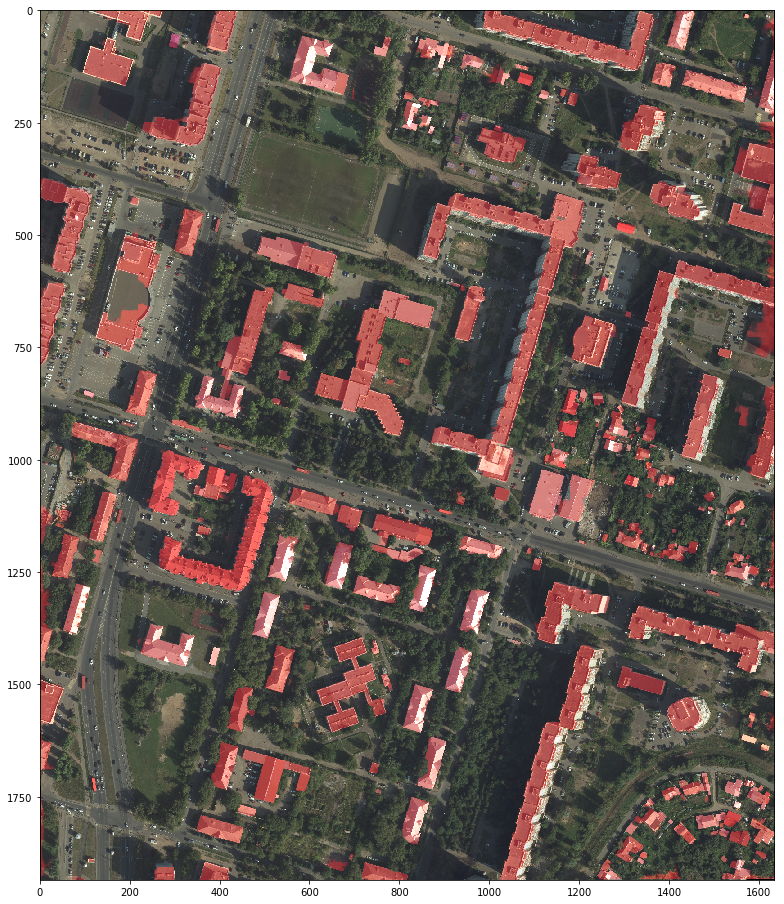

In [16]:
plt.figure(figsize=(16, 16))
plt.imshow(image_1[::4, ::4])
plt.show()